# Face Recognition Bootcamp Project using Milvus Vector Database.

This demo uses [Milvus Vector Database](https://milvus.io/) for storing face embeddings & performing face similaity search based on those stored embeddings. Milvus is a vector similarity search engine, a tool that lets you quickly find the closest matching vector in a pool of billions of vectors.

The system architecture is as below:
<p align="center">
<img src="workflow.png" width = "500" height = "600" alt="system_arch" />
</p>

## Data Source

This demo uses the dataset of around 800k images consisting of 1100 Famous Celebrities and an Unknown class to classify unknown faces. All the images have been scraped from Google and contains no duplicate images. Each Celebrity class(folder) consists approximately 700-800 images and the Unknown class consists of 100k images.

> Note: You can also use other images for testing. This system supports the following formats: .jpg and .png.
Directory Structure:  
The file loader used in this requires that the folders containing the images are subfolders. 

```bash
── celeb_reorganized  
    |── 1
    |   |── image1.jpg  
    |   |── image2.jpg
    |   |── .....
    |── 2
        |── imageX.jpg  
        |── ...
   |── ...
```

> Note: You can also use other images for testing. This example only requires that the images are PIL compatible.

## Requirements

|  Packages |  Servers |
| --------------- | -------------- |
| pymilvus        | milvus-1.0   |
| facenet_pytorch |
| torch |
| torchvision |
| matplotlib |
| pillow |
| numpy |
| pandas |
| gdown |

Refer to [requirements.txt](./requirements.txt) for required packages. 

## Up and Running

### Install Packages
Install the required python packages with `requirements.txt`.

In [23]:
! pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


### Start Milvus

First, you need to start Milvus & Mysql servers.
Refer [Milvus Standalone](https://milvus.io/docs/v2.0.0/install_standalone-docker.md) for how to install Milvus. Please note the Milvus version should match pymilvus version in [config.py](./server/src/config.py).

In [24]:
! docker kill $(docker ps -a -q)

35f527203eff


In [25]:
! docker rm $(docker ps -a -q)

35f527203eff


In [26]:
! docker run -d --name milvus_cpu_1.1.0 -p 19530:19530 -p 19121:19121 -v /home/$USER/milvus/db:/var/lib/milvus/db -v /home/$USER/milvus/conf:/var/lib/milvus/conf -v /home/$USER/milvus/logs:/var/lib/milvus/logs -v /home/$USER/milvus/wal:/var/lib/milvus/wal milvusdb/milvus:1.1.0-cpu-d050721-5e559c

0c7b72b80072b27b00e51cff190a390c9154c8098214b7bfee0cae312a6bb5ec


### Confirm the running state of Milvus: 

In [27]:
! docker ps

CONTAINER ID   IMAGE                                      COMMAND                  CREATED         STATUS        PORTS                                                                                          NAMES
0c7b72b80072   milvusdb/milvus:1.1.0-cpu-d050721-5e559c   "/tini -- /var/lib/m…"   2 seconds ago   Up 1 second   0.0.0.0:19121->19121/tcp, :::19121->19121/tcp, 0.0.0.0:19530->19530/tcp, :::19530->19530/tcp   milvus_cpu_1.1.0


### 2. Start API Server

Then to start the system server, and it provides HTTP backend services.

- **Install the Python packages**

```
$ git clone https://github.com/milvus-io/bootcamp.git
$ pip install -m requirements.txt
```

- **Set configuration**

Modify the parameters according to your own environment. Here listing some parameters that need to be set, for more information please refer to [config.py](./server/src/config.py).

| **Parameter**    | **Description**                                       | **Default setting** |
| ---------------- | ----------------------------------------------------- | ------------------- |
| MILVUS_HOST      | The IP address of Milvus, you can get it by ifconfig. | 127.0.0.1           |
| MILVUS_PORT      | Port of Milvus.                                       | 19530               |
| VECTOR_DIMENSION | Dimension of the vectors.                             | 1000                |
| MYSQL_HOST       | The IP address of Mysql.                              | 127.0.0.1           |
| MYSQL_PORT       | Port of Mysql.                                        | 3306                |
| DEFAULT_TABLE    | The milvus and mysql default collection name.         | milvus_img_search   |


### **Prepare the dataset for Milvus Search Engine**

```
$ python3 prepare_data.py
```

## Code Overview

### Connecting to Servers

We first start off by connecting to the servers. In this case the docker containers are running on localhost and the ports are the default ports. 

In [1]:
# Neccessary Imports
import torch
import os
import pickle
import prepare_data
import argparse
import numpy as np
import pandas as pd
import matplotlib.image as mpimg

from milvus import Milvus, IndexType, MetricType, Status
from PIL import Image, ImageDraw
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision import datasets
from torch.utils.data import DataLoader
from  matplotlib import pyplot as plt

In [2]:
# Setting configuration
_HOST = '127.0.0.1'

_PORT = '19530' 

collection_name = 'celebrity_faces_'

_DIM = 512  

_INDEX_FILE_SIZE = 32  

id_to_identity = None

milvus = Milvus(_HOST, _PORT)

In [3]:
# Selecting the device CPU/GPU 
workers = 0 if os.name == 'nt' else 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {} 💻️'.format(device))

Running on device: cpu 💻️


### Face Detection using MTCNN model

In [4]:
# Face detection using MTCNN
mtcnn = MTCNN(
        image_size=160, margin=0, min_face_size=20,
        thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, keep_all=True,
        device=device
    )

In [5]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

### Turning all of the image data into embeddings.

In [6]:
# Turns all the celeb image data into embeddings.
def preprocess_images():

    def collate_fn(x):
        return x[0]

    dataset = datasets.ImageFolder('./celeb_reorganized')
    dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
    loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)


    encoded = []
    identity = []
    count = len(loader)

    for x, y in loader:
        try:
            x_aligned, prob = mtcnn(x, return_prob=True)
        except:
            print(x)
            plt.imshow(x)
            plt.show()
        if x_aligned is not None:
            x_aligned = x_aligned.to(device)
            embeddings = resnet(x_aligned).detach().cpu()
            embeddings = embeddings.numpy()
            encoded.append(embeddings)
            for x in range(embeddings.shape[0]):
                identity.append(dataset.idx_to_class[y])
            if count %1000 == 0:
                print(count, x_aligned.shape, dataset.idx_to_class[y])
            count -= 1
           
    encoded = np.concatenate(encoded, 0)
    encoded = np.squeeze(encoded)
    print(encoded.shape)
    identity = np.array(identity)
    np.save("identity_save.npy", identity)
    np.save("encoded_save.npy", encoded)
    encoded = np.load("encoded_save.npy")
    identity = np.load("identity_save.npy")
    print(encoded.shape, identity.shape)



### Creating Milvus collection

In [7]:
# Creates a milvus collection
def create_collection():
    global id_to_identity
    print("Creating a collection on Milvus Database...📊️")
    status, ok = milvus.has_collection(collection_name)
    if not ok:
        param = {
            'collection_name': collection_name,
            'dimension': _DIM,
            'index_file_size': _INDEX_FILE_SIZE,
            'metric_type': MetricType.L2 
        }

        milvus.create_collection(param)
        print("Collection created.✅️")
        return 1
    else:
        print("Collection is present already!✅️")
        try:
            with open ('id_to_class', 'rb') as fp:
                id_to_identity = pickle.load(fp)
            return 0
        except:
            return 1

### Importing embeddings into the created collection on Milvus Database

In [8]:
# Imports all the celeb embeddings into the created collection
def first_load():
    global id_to_identity
    print("Loading in encoded vectors...")
    encoded = np.load("encoded_save.npy")
    identity = np.load("identity_save.npy")

    encoded = np.array_split(encoded, 4, axis=0)
    identity = identity.astype(int)

    identity = np.array_split(identity, 4, axis=0)

    id_to_identity = []

    for x in range(len(encoded)):
        print(encoded[x].shape, encoded[x].dtype, identity[x])
        status, ids = milvus.insert(collection_name=collection_name, records=encoded[x])
        if not status.OK():
            print("Insert failed: {}".format(status))
        else:
            for z in range(len(ids)):
                id_to_identity.append((ids[z], identity[x][z]))

    milvus.flush([collection_name])

    with open('id_to_class', 'wb') as fp:
        pickle.dump(id_to_identity, fp)
    print("Vectors loaded in.")


### Extract the embeddings of detected Faces

In [9]:

# Gets embeddings for all the faces in the image. 
def get_image_vectors(file_loc):
    img = Image.open(file_loc)
    bbx, prob = mtcnn.detect(img)
    embeddings = None
    if (bbx is not None):
        face_cropped = mtcnn.extract(img,bbx,None).to(device)
        embeddings = resnet(face_cropped).detach().cpu()
        embeddings = embeddings.numpy()
        draw = ImageDraw.Draw(img)
        for i, box in enumerate(bbx):
            draw.rectangle(box.tolist(), outline=(255,0,0))
            draw.text((box.tolist()[0] + 2,box.tolist()[1]), "Face-" + str(i), fill=(255,0,0))

    return embeddings, img


### Indexing the data for faster Similarity search

In [10]:
# Indexes the collection
def index():
    print("Indexing the data...🔢️")

    index_param = {
        'nlist': 4096
    }

    status = milvus.create_index(collection_name, IndexType.IVF_FLAT, index_param)

    print("Indexed!✅️")

### Similarity Search

In order to search similar items for or retrieve a given image, we first put the image through the face detection & embedding process as which was used in the previous step of image storage. Then we get a vector for the input image and go through Milvus with similarity search of vectors.

In [11]:
# Search for the nearest neighbor of the given image. 
def search_image(file_loc):
    query_vectors, insert_image = get_image_vectors(file_loc)

    search_param = {
        "nprobe": 2056
    }

    print("Searching for the image ...🧐️")

    param = {
        'collection_name': collection_name,
        'query_records': query_vectors,
        'top_k': 1,
        'params': search_param,
    }

    status, results = milvus.search(**param)
    if status.OK():
        temp = []
        plt.imshow(insert_image)
        for x in range(len(results)):
            for i, v in id_to_identity:
                if results[x][0].id == i:
                    temp.append(v)
        for i, x in enumerate(temp):
            fig = plt.figure()
            fig.suptitle('Face-' + str(i) + ", Celeb Folder: " + str(x))
            currentFolder = './celeb_reorganized/' + str(x)
            total = min(len(os.listdir(currentFolder)), 6)

            for i, file in enumerate(os.listdir(currentFolder)[0:total], 1):
                fullpath = currentFolder+ "/" + file
                img = mpimg.imread(fullpath)
                plt.subplot(2, 3, i)
                plt.imshow(img)
        plt.show(block = False)
        if(len(temp))!=0:
            print("Wohoo, Similar Images found!🥳️")
        print(temp)


### Delete Collection 

In [12]:
# Delete the collection
def delete_collection():
    status = milvus.drop_collection(collection_name)

### Input an image & Test 

Creating a collection on Milvus Database...📊️
Collection is present already!✅️
Indexing the data...🔢️
Indexed!✅️
Searching for the image ...🧐️


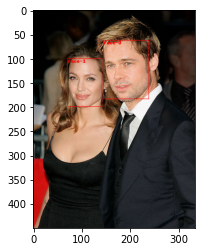

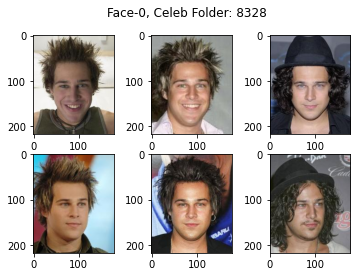

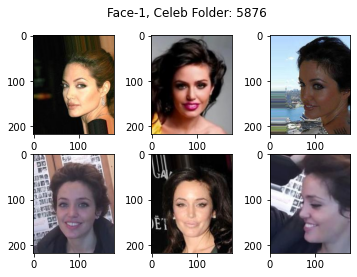

Wohoo, Similar Images found!🥳️
[8328, 5876]


In [16]:
if not os.path.isdir("./celeb_reorganized"):
        print("Unzipping Data...")
        prepare_data.unzip()
        print("Reorganizing Data...")
        prepare_data.reorganize()
if not (os.path.isfile("./encoded_save.npy") and os.path.isfile("./identity_save.npy")):
    print("Processing Images...")
    delete_collection()
    preprocess_images()
if not (os.path.isfile("./id_to_class")):
    delete_collection()
if create_collection():
    first_load()
index()
search_image("test.jpg")
plt.show()

## Conclusion
This notebook shows how to search for similar faces & perform face recognition with Milvus vector database. 